In [50]:
import yfinance as yf
import pandas as pd
import numpy as np
import hvplot.pandas
from finta import TA

**YFinance:**

In [51]:
# set ticker ('BTC-USD', 'ETH-USD')
ticker = 'ETH-USD'
cc = yf.Ticker(f"{ticker}")

# set dates for historical data
start = '2018-02-01'
end = '2023-01-24'

hist = cc.history(start=f"{start}", end=f"{end}")

In [52]:
# just close column
historical = pd.DataFrame(hist)
historical_close = historical.drop(['Open','High', 'Low','Volume', 'Dividends', 'Stock Splits'], axis=1)
historical_close.head()

,Close
Date,
2018-02-01 00:00:00+00:00,1036.790039
2018-02-02 00:00:00+00:00,915.784973
2018-02-03 00:00:00+00:00,964.018982
2018-02-04 00:00:00+00:00,834.682007
2018-02-05 00:00:00+00:00,697.950989


**Fear and Greed API:**

In [53]:
import requests

In [54]:
r = requests.get('https://api.alternative.me/fng/?limit=0')

In [55]:
# select 'data' and add to a dataframe
fg_df = pd.DataFrame(r.json()['data'])

# convert 'value' to int
fg_df.value = fg_df.value.astype(int)

# convert time format to datetime
fg_df.timestamp = pd.to_datetime(fg_df.timestamp, unit='s' )

# set date as index
fg_df.set_index('timestamp', inplace=True)

# drop all columns except 'value'
fg_df = fg_df.drop(['value_classification', 'time_until_update'], axis=1)

# flip oldest data to the top
fg_df = fg_df[::-1]

# convert date format to match 'historical_close'
fg_df.index = pd.to_datetime(fg_df.index).tz_localize('Etc/UCT')

fg_df.head()

,value
timestamp,
2018-02-01 00:00:00+00:00,30
2018-02-02 00:00:00+00:00,15
2018-02-03 00:00:00+00:00,40
2018-02-04 00:00:00+00:00,24
2018-02-05 00:00:00+00:00,11


**Combined:**

In [56]:
# rename index to match fg_df
historical.index.name = 'timestamp'

# combine historical price data with historical fear and greed
combined_df = pd.concat([fg_df, historical_close], axis=1, join='outer')

combined_df.head()

,value,Close
timestamp,,
2018-02-01 00:00:00+00:00,30.0,1036.790039
2018-02-02 00:00:00+00:00,15.0,915.784973
2018-02-03 00:00:00+00:00,40.0,964.018982
2018-02-04 00:00:00+00:00,24.0,834.682007
2018-02-05 00:00:00+00:00,11.0,697.950989


**Backtest:**

In [57]:
combined_df_ = combined_df.copy()

# add 'change' column using pct_change on 'Close'
combined_df_['change'] = combined_df_['Close'].pct_change()

**Fear and Greed Algorithm Logic:**

- position 1.0 = Long Crypto (uptrend)

- position -1.0 = Short Crypto (downtrend)

- position 0.0 = Hold Stablecoin (no trend)

In [58]:
# algo
# set 'position' column to 0
combined_df_['position'] = 0

# short when f&g is over 94 (f&g > 94 = -1)
for index, row in combined_df_.iterrows():
    if row['value'] >= 95:
        combined_df_.loc[index, 'position'] = -1.0

# long when f&g is over 45 and under 94 (93 > f&g > 45 = 1)
    elif row['value'] >= 46:
        combined_df_.loc[index, 'position'] = 1.0

# short when f&g is over 24 and less than 46 (46 > f&g > 24 = -1)
    elif row['value'] >= 25:
        combined_df_.loc[index, 'position'] = -1.0

# hold stables under 25 (f&g < 25 = 0.0)
    elif row['value'] < 25:
        combined_df_.loc[index, 'position'] = 0

combined_df_ = combined_df_.dropna()
combined_df_.head(12)

,value,Close,change,position
timestamp,,,,
2018-02-02 00:00:00+00:00,15.0,915.784973,-0.116711,0
2018-02-03 00:00:00+00:00,40.0,964.018982,0.052670,-1
2018-02-04 00:00:00+00:00,24.0,834.682007,-0.134164,0
2018-02-05 00:00:00+00:00,11.0,697.950989,-0.163812,0
2018-02-06 00:00:00+00:00,8.0,793.122009,0.136358,0
2018-02-07 00:00:00+00:00,36.0,757.067993,-0.045458,-1
2018-02-08 00:00:00+00:00,30.0,817.807007,0.080229,-1
2018-02-09 00:00:00+00:00,44.0,883.864990,0.080775,-1
2018-02-10 00:00:00+00:00,54.0,860.414978,-0.026531,1


In [59]:
# number of each position
combined_df_['position'].value_counts()

-1    673
 1    648
 0    493
Name: position, dtype: int64

**Returns:**

In [60]:
# calculate returns
strategy_returns = combined_df_.position.shift() * combined_df_.change

# plot to compare
fg_strat_plt = (strategy_returns +1).cumprod().hvplot(label = 'FG_strat')
cc_returns_plt = (combined_df_.change +1).cumprod().hvplot(label = 'CC')
fg_strat_plt * cc_returns_plt

:Overlay
   .Curve.FG_strat :Curve   [timestamp]   (0)
   .Curve.CC       :Curve   [timestamp]   (change)

In [61]:
# returns
fg_return = (strategy_returns + 1).cumprod()
cc_return = (combined_df_.change + 1).cumprod()
fg_final = fg_return[-1]
cc_final = cc_return[-1]
print(f'Fear and Greed strategy returns:  {round(fg_final, 2)}')
print(f'CC returns:  {round(cc_final, 2)}')

Fear and Greed strategy returns:  53.4
CC returns:  1.51


In [62]:
initial_investment = 1000

fg_inv_returns  = initial_investment * fg_final
cc_inv_returns = initial_investment * cc_final

print(f"Buying ${initial_investment} and holding: ${round(cc_inv_returns, 2)}")
print(f"${initial_investment} with fear and greed strategy: ${round(fg_inv_returns, 2)}")

Buying $1000 and holding: $1513.9
$1000 with fear and greed strategy: $53402.02


**Machine Learning (where: Target = actual trend)(1):**

In [63]:
import pandas_ta as pa
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

**Finding actual trend:**

In [64]:
# full df to calculate actual trend
# set ticker ('BTC-USD', 'ETH-USD')
ticker = 'ETH-USD'
cc = yf.Ticker(f"{ticker}")

# set dates for historical data
start = '2018-02-01'
end = '2023-01-24'

histo = cc.history(start=f"{start}", end=f"{end}")

# all columns for finding target
historical_ = pd.DataFrame(histo)
historical_ = historical_.drop(['Dividends', 'Stock Splits'], axis=1)
historical_['signal'] = combined_df_['position']
historical_ = historical_.dropna()
historical_.head()


,Open,High,Low,Close,Volume,signal
Date,,,,,,
2018-02-02 00:00:00+00:00,1035.770020,1035.770020,757.979980,915.784973,6713290240,0.0
2018-02-03 00:00:00+00:00,919.210999,991.942993,847.690002,964.018982,3243480064,-1.0
2018-02-04 00:00:00+00:00,964.666992,969.031982,805.064026,834.682007,2997090048,0.0
2018-02-05 00:00:00+00:00,834.958008,856.645996,644.598999,697.950989,4269530112,0.0
2018-02-06 00:00:00+00:00,707.737000,796.439026,574.419006,793.122009,6518269952,0.0


<AxesSubplot:>

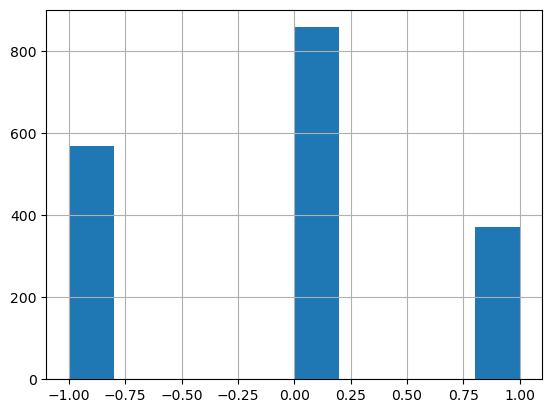

In [65]:
# Target column to find actual trend

pipdiff = 2500*1e-4 #for TP
SLTPRatio = 1/16 #pipdiff/Ratio gives SL
def mytarget(barsupfront, historical_):
    length = len(historical_)
    high = list(historical_['High'])
    low = list(historical_['Low'])
    close = list(historical_['Close'])
    open = list(historical_['Open'])
    trendcat = [None] * length
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)
        
            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = -1 # downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 1 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

# pitfall one category high frequency
historical_['Target'] = mytarget(14, historical_)

historical_['Target'].hist()

In [66]:
# add target to combined_df_
combined_df_['Target'] = historical_['Target']
# copy and clean dataframe
target_ml = combined_df_.copy()
# add RSI
target_ml['RSI'] = pa.rsi(target_ml.Close, length=16)
# get signal column
target_ml['Signal'] = target_ml['position']
# drop columns and na
target_ml = target_ml.drop(["Close", "change", "position"],axis=1)
target_ml = target_ml.dropna()
target_ml.tail()

,value,Target,RSI,Signal
timestamp,,,,
2023-01-03 00:00:00+00:00,26.0,1.0,47.904375,-1
2023-01-04 00:00:00+00:00,29.0,-1.0,55.155030,-1
2023-01-05 00:00:00+00:00,29.0,0.0,53.986257,-1
2023-01-06 00:00:00+00:00,26.0,-1.0,57.009417,-1
2023-01-07 00:00:00+00:00,25.0,1.0,55.951791,-1


In [67]:
# get dummies on signal column
attributes = ['value', 'Target', 'RSI', 'Signal']
target_df = target_ml[attributes].copy()

target_ml['Signal'] = pd.Categorical(target_ml['Signal'])
dummies = pd.get_dummies(target_ml['Signal'], prefix='signal')
target_df = target_df.drop(['Signal'], axis=1)
target_df = pd.concat([target_df, dummies], axis=1)
target_df.head()

,value,Target,RSI,signal_-1,signal_0,signal_1
timestamp,,,,,,
2018-02-18 00:00:00+00:00,63.0,1.0,53.324972,0,0,1
2018-02-19 00:00:00+00:00,67.0,0.0,55.183005,0,0,1
2018-02-20 00:00:00+00:00,74.0,0.0,50.018759,0,0,1
2018-02-21 00:00:00+00:00,54.0,0.0,45.743818,0,0,1
2018-02-22 00:00:00+00:00,44.0,0.0,42.570200,1,0,0


**Neural Network(1):**

In [68]:
from sklearn.neural_network import MLPClassifier

# set X and y
attributes = ['value', 'RSI', 'signal_-1', 'signal_0', 'signal_-1']
X = target_df[attributes].shift().dropna()
y = target_df['Target'].iloc[1:]


# split into testing and training
train_pct_index = int(0.6 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

# Scale features
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# set up NN model
NN = MLPClassifier(hidden_layer_sizes=(5, 40, 30, 3), random_state=100, verbose=0, max_iter=1000, activation='relu')
NN.fit(X_train, y_train)
pred_train = NN.predict(X_train)
pred_test = NN.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)

# print accuracy
print('Train Results:')
print("Accuracy: {:.4%}".format(acc_train))
print('Test Results:')
print("Accuracy: {:.4%}".format(acc_test)) 

Train Results:
Accuracy: 51.8727%
Test Results:
Accuracy: 25.1052%


In [69]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)

              precision    recall  f1-score   support

        -1.0       0.53      0.91      0.67       510
         0.0       0.48      0.36      0.41       243
         1.0       0.00      0.00      0.00       315

    accuracy                           0.52      1068
   macro avg       0.34      0.43      0.36      1068
weighted avg       0.36      0.52      0.41      1068

              precision    recall  f1-score   support

        -1.0       0.09      0.89      0.16        57
         0.0       0.91      0.21      0.34       605
         1.0       0.00      0.00      0.00        51

    accuracy                           0.25       713
   macro avg       0.33      0.37      0.17       713
weighted avg       0.78      0.25      0.30       713



/opt/anaconda3/envs/dev/envs/algotrading/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/envs/algotrading/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/envs/algotrading/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

**SVM(1):**

In [70]:
# Imports
from sklearn import svm
from sklearn.metrics import classification_report

In [71]:
# Create model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
svm_pred = svm_model.predict(X_train_scaled)

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_train, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.53      0.93      0.67       510
         0.0       0.51      0.30      0.38       243
         1.0       0.33      0.03      0.06       315

    accuracy                           0.52      1068
   macro avg       0.46      0.42      0.37      1068
weighted avg       0.47      0.52      0.43      1068



In [73]:
# Create a new empty predictions DataFrame:
testing_signal_predictions = svm_model.predict(X_test_scaled)

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = testing_signal_predictions

# Add the actual returns to the DataFrame
predictions_df['Actual_Returns'] = combined_df_["change"]

# Add the strategy returns to the DataFrame
predictions_df['Strategy_Returns'] = predictions_df["Actual_Returns"] * predictions_df["Predicted"]

# Review the DataFrame
display(predictions_df.head())

,Predicted,Actual_Returns,Strategy_Returns
timestamp,,,
2021-01-25 00:00:00+00:00,1.0,-0.048286,-0.048286
2021-01-26 00:00:00+00:00,0.0,0.024647,0.000000
2021-01-27 00:00:00+00:00,1.0,-0.076541,-0.076541
2021-01-28 00:00:00+00:00,0.0,0.063283,0.000000
2021-01-29 00:00:00+00:00,-1.0,0.037547,-0.037547


<AxesSubplot:xlabel='timestamp'>

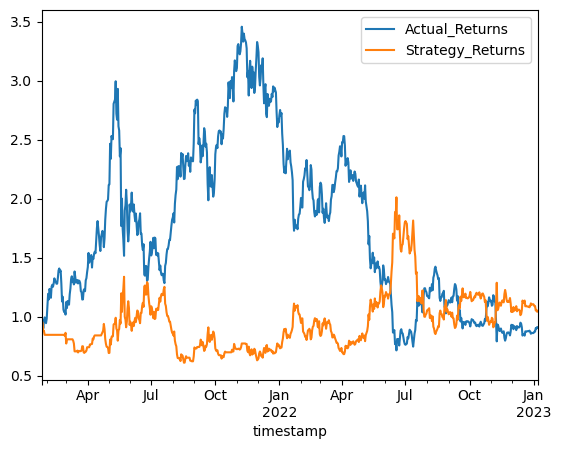

In [74]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual_Returns", "Strategy_Returns"]]).cumprod().plot()

**Machine Learning (where: Target = Signal from F&G strategy)(2):**

In [75]:
ML_df = combined_df_.copy()
# add RSI
ML_df['RSI'] = pa.rsi(ML_df.Close, length=16)
ML_df = ML_df.dropna()
ML_df.head()

,value,Close,change,position,Target,RSI
timestamp,,,,,,
2018-02-18 00:00:00+00:00,63.0,923.921021,-0.051528,1,1.0,53.324972
2018-02-19 00:00:00+00:00,67.0,943.864990,0.021586,1,0.0,55.183005
2018-02-20 00:00:00+00:00,74.0,895.370972,-0.051378,1,0.0,50.018759
2018-02-21 00:00:00+00:00,54.0,849.971008,-0.050705,1,0.0,45.743818
2018-02-22 00:00:00+00:00,44.0,812.844971,-0.043679,-1,0.0,42.570200


In [76]:
# features
X2 = ML_df[['RSI', 'value']].shift().dropna()
X2.head(5)

,RSI,value
timestamp,,
2018-02-19 00:00:00+00:00,53.324972,63.0
2018-02-20 00:00:00+00:00,55.183005,67.0
2018-02-21 00:00:00+00:00,50.018759,74.0
2018-02-22 00:00:00+00:00,45.743818,54.0
2018-02-23 00:00:00+00:00,42.570200,44.0


In [77]:
# Create the target set (-1 = Short, 0 = Stables, 1 = Long)
y2 = ML_df['position']
y2.value_counts()

-1    658
 1    635
 0    489
Name: position, dtype: int64

In [78]:
# start of the training period
training_begin = X2.index.min()
# ending period for the training data with an offset of 40 months
training_end = X2.index.min() + DateOffset(months=40)
display(training_begin)
display(training_end)


Timestamp('2018-02-19 00:00:00+0000', tz='UTC')

Timestamp('2021-06-19 00:00:00+0000', tz='UTC')

In [79]:
# Generate the X_train and y_train DataFrames
X2_train = X2.loc[training_begin:training_end]
y2_train = y2.loc[training_begin:training_end]

# Generate the X_test and y_test DataFrames
X2_test = X2.loc[training_end:]
y2_test = y2.loc[training_end:]

display(X2_train.head())
display(X2_test.head())

,RSI,value
timestamp,,
2018-02-19 00:00:00+00:00,53.324972,63.0
2018-02-20 00:00:00+00:00,55.183005,67.0
2018-02-21 00:00:00+00:00,50.018759,74.0
2018-02-22 00:00:00+00:00,45.743818,54.0
2018-02-23 00:00:00+00:00,42.570200,44.0


,RSI,value
timestamp,,
2021-06-19 00:00:00+00:00,41.026683,25.0
2021-06-20 00:00:00+00:00,39.997179,23.0
2021-06-21 00:00:00+00:00,41.977104,21.0
2021-06-22 00:00:00+00:00,35.405009,23.0
2021-06-23 00:00:00+00:00,35.183431,10.0


In [80]:
# Scale features

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X2_scaler = scaler.fit(X2_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X2_train_scaled = X2_scaler.transform(X2_train)
X2_test_scaled = X2_scaler.transform(X2_test)

**Neural Network (2):**

In [81]:
from sklearn.neural_network import MLPClassifier


# set up NN model
NN = MLPClassifier(hidden_layer_sizes=(5, 40, 30, 3), random_state=100, verbose=0, max_iter=1000, activation='relu')
NN.fit(X2_train, y2_train)
pred_train2 = NN.predict(X2_train)
pred_test2 = NN.predict(X2_test)
acc_train2 = accuracy_score(y2_train, pred_train2)
acc_test2 = accuracy_score(y2_test, pred_test2)

# print accuracy
print('Train Results:')
print("Accuracy: {:.4%}".format(acc_train2))
print('Test Results:')
print("Accuracy: {:.4%}".format(acc_test2)) 

Train Results:
Accuracy: 85.6672%
Test Results:
Accuracy: 83.8028%


In [82]:
# generate confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train2 = confusion_matrix(y2_train, pred_train2)
matrix_test2 = confusion_matrix(y2_test, pred_test2)

report_train2 = classification_report(y2_train, pred_train2)
report_test2 = classification_report(y2_test, pred_test2)

print(report_train2)
print(report_test2)

              precision    recall  f1-score   support

          -1       0.82      0.79      0.81       447
           0       0.82      0.87      0.85       258
           1       0.91      0.91      0.91       509

    accuracy                           0.86      1214
   macro avg       0.85      0.86      0.85      1214
weighted avg       0.86      0.86      0.86      1214

              precision    recall  f1-score   support

          -1       0.78      0.79      0.78       211
           0       0.85      0.86      0.85       232
           1       0.92      0.88      0.90       125

    accuracy                           0.84       568
   macro avg       0.85      0.84      0.85       568
weighted avg       0.84      0.84      0.84       568



**SVM(2):**

In [83]:
# Create model
svm_model2 = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model2 = svm_model2.fit(X2_train_scaled, y2_train)

# Use the trained model to predict the trading signals for the training data
svm_pred2 = svm_model2.predict(X2_train_scaled)

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report2 = classification_report(y2_train, svm_pred2)

# Print the classification report
print(svm_testing_report2)

              precision    recall  f1-score   support

          -1       0.80      0.80      0.80       447
           0       0.82      0.84      0.83       258
           1       0.91      0.91      0.91       509

    accuracy                           0.85      1214
   macro avg       0.84      0.85      0.85      1214
weighted avg       0.85      0.85      0.85      1214



In [84]:
# Create a new empty predictions DataFrame:
testing_signal_predictions2 = svm_model2.predict(X2_test_scaled)

# Create a predictions DataFrame
predictions_df2 = pd.DataFrame(index=X2_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df2['Predicted'] = testing_signal_predictions2

# Add the actual returns to the DataFrame
predictions_df2['Actual_Returns'] = combined_df_["change"]

# Add the strategy returns to the DataFrame
predictions_df2['Strategy_Returns'] = predictions_df2["Actual_Returns"] * predictions_df2["Predicted"]

# Review the DataFrame
predictions_df2.head()

,Predicted,Actual_Returns,Strategy_Returns
timestamp,,,
2021-06-19 00:00:00+00:00,-1,-0.023853,0.023853
2021-06-20 00:00:00+00:00,0,0.031152,0.000000
2021-06-21 00:00:00+00:00,0,-0.159332,-0.000000
2021-06-22 00:00:00+00:00,0,-0.007147,-0.000000
2021-06-23 00:00:00+00:00,0,0.061221,0.000000


**SVM plot (2) (Target = Signal from F&G startegy):**

<AxesSubplot:xlabel='timestamp'>

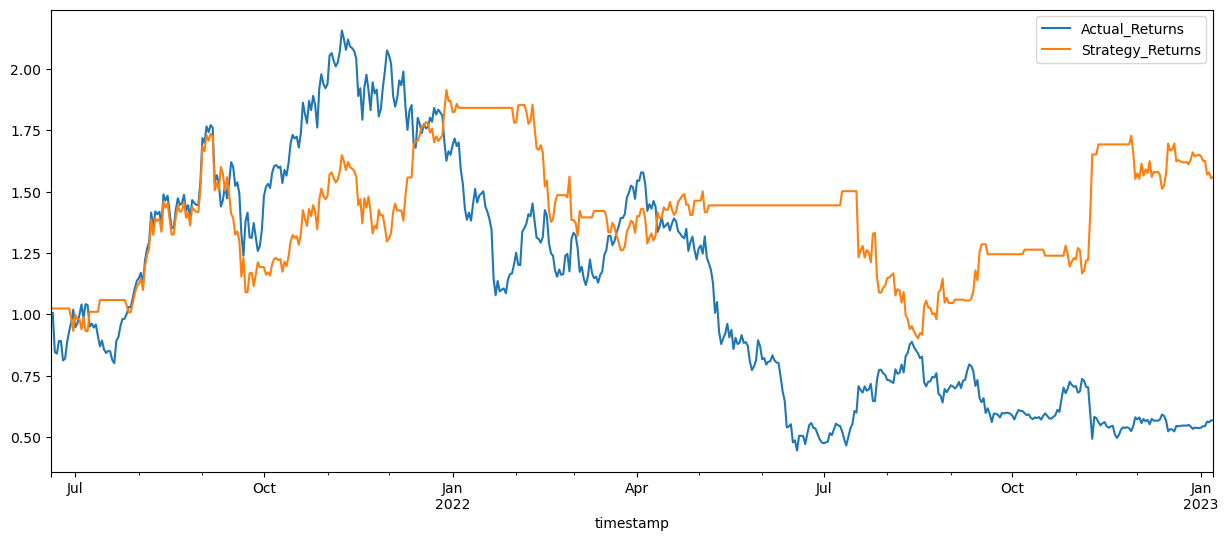

In [93]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df2[["Actual_Returns", "Strategy_Returns"]]).cumprod().plot(figsize=(15,6))

**SVM plot (1) (Target = actual trend):**

<AxesSubplot:xlabel='timestamp'>

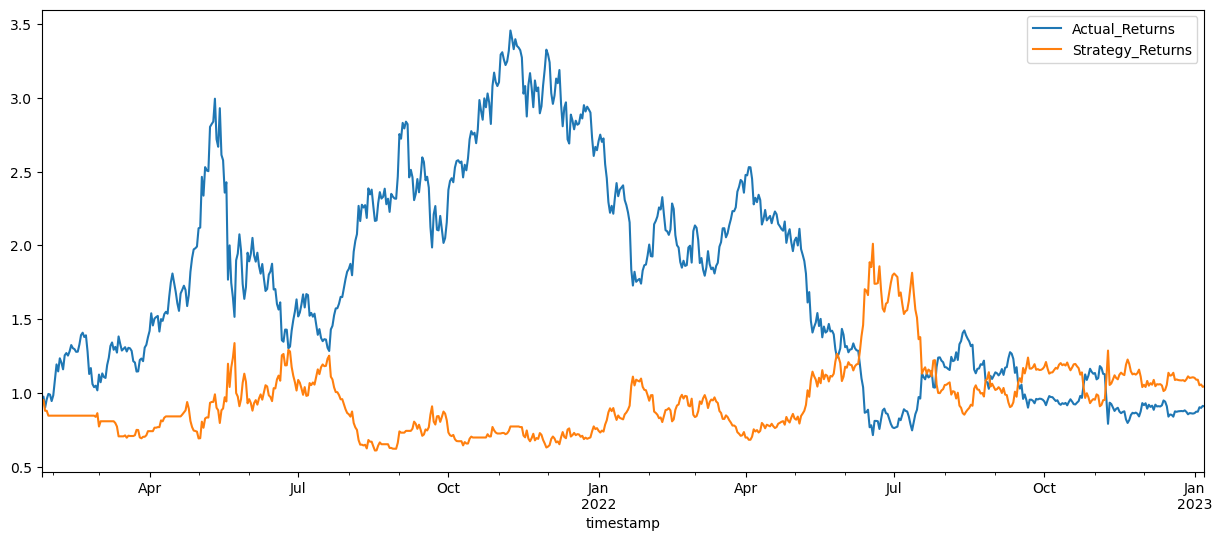

In [94]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual_Returns", "Strategy_Returns"]]).cumprod().plot(figsize=(15,6))

In [103]:
# features to CSV
features_ = combined_df_.copy()
features_.rename(columns={"value": "FG"}, inplace=True)
features_ = features_.drop(columns=['Target'])

# save features as csv (ETH)
features_.to_csv('features_ETH.csv')
